# Measurements of Relativistic Corrections

Start in the appropriate notebook directory.

In [1]:
# %cd /mnt/lustre/mikewang/projects/HorizonGRound/notebooks/

Set up the appropriate paths.

In [2]:
import os, sys

current_file_dir = os.getcwd()
sys.path.insert(0, "".join([current_file_dir, "/../"]))
os.environ['HDF5_USE_FILE_LOCKING'] = 'FALSE'

from config.program import data_dir, stylesheet

publication_dir = data_dir/"output"/"publication"

Import the appropriate packages.

In [3]:
import glob
import re
from collections import defaultdict

import corner
import h5py
import matplotlib.pyplot as plt
import numpy as np

from matplotlib.ticker import MultipleLocator, AutoMinorLocator

plt.style.use(stylesheet)

## Relativistic correction function quantiles

In [4]:
distilled_chain_files = glob.glob("/".join([str(publication_dir), "dense_points", "relcrct_z*"]))

In [5]:
sigma_levels = [-2, -1, 0, 1, 2]
quantile_levels = [0.022750, 0.158655, 0.5, 0.841345, 0.977250]

quantiles = dict(zip(sigma_levels, quantile_levels))

In [6]:
dense_redshifts = []
gz_quantiles = defaultdict(list)
for chain_file in sorted(distilled_chain_files):
    dense_redshifts.append(float(re.search("_z(?P<redshift>.*?)_", chain_file).group('redshift')))
    with h5py.File(chain_file, 'r') as chain_data:
        distilled = chain_data['distill/chain'][()]
        gz_q = corner.quantile(distilled[:], q=quantile_levels)
    for sigma_level_idx, sigma_level in enumerate(sigma_levels):
        gz_quantiles[sigma_level].append(gz_q[sigma_level_idx])

In [7]:
discontinuity_pos = np.searchsorted(dense_redshifts, 2.2)

if dense_redshifts[discontinuity_pos] == 2.2:
    del dense_redshifts[discontinuity_pos]
    for sigma_level in evolution_bias_quantiles:
        del gz_quantiles[sigma_level][discontinuity_pos]
        
low_redshift_part = slice(0, discontinuity_pos)
high_redshift_part = slice(discontinuity_pos, None)

## Relativistic correction function measurements

In [8]:
measured_chain_files = glob.glob("/".join([str(publication_dir), "eBOSS_binning", "relcrct_z*"]))

In [9]:
estimate_levels = [0.158655, 0.5, 0.841345]

In [10]:
measured_redshifts = []
gz_estimates = defaultdict(list)
for chain_file in sorted(measured_chain_files):
    measured_redshifts.append(float(re.search("_z(?P<redshift>.*?)_", chain_file).group('redshift')))
    with h5py.File(chain_file, 'r') as chain_data:
        distilled = chain_data['distill/chain'][()]
        gz_e = corner.quantile(distilled[:], q=estimate_levels)
    for estimate_idx, estimate_level in enumerate([-1, 0, 1]):
        gz_estimates[estimate_level].append(gz_e[estimate_idx])

## Relativistic correction function measurements

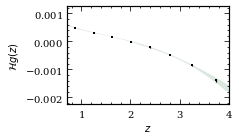

In [11]:
LINESTYLE = '-'
COLOUR = '#A3C1AD'
ALPHA = 0.75

fig = plt.figure("corrections", figsize=(2.9, 1.8))

plt.errorbar(
    measured_redshifts, gz_estimates[0], 
    yerr=[np.subtract(gz_estimates[0], gz_estimates[-1]), np.subtract(gz_estimates[1], gz_estimates[0])],
    fmt='s', zorder=3
)
plt.fill_between(
    dense_redshifts, gz_quantiles[-2], gz_quantiles[2],
    facecolor=COLOUR, alpha=0.5*ALPHA, zorder=1
)

plt.xlim(min(dense_redshifts), max(dense_redshifts))
plt.ylim(-0.00225, 0.00125)
plt.yticks(np.arange(-0.002, 0.002, step=0.001))
plt.gca().xaxis.set_minor_locator(AutoMinorLocator())
plt.gca().yaxis.set_minor_locator(AutoMinorLocator())
plt.xlabel(r"$z$")
plt.ylabel(r"$\mathcal{H}g(z)$")

fig.savefig(publication_dir/"gallery"/"relativistic_corrections.pdf")